In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
import cv2
import torch
from torch.autograd import  Variable
from faster_rcnn.utils.images import imshow
from faster_rcnn.utils.cython_bbox import bbox_overlaps

from faster_rcnn.fastrcnn.bbox_transform import bbox_transform, bbox_transform_inv
import cPickle
from faster_rcnn.rpn_msr.proposal_target_layer_2 import  ProposalTargetLayer
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
import gc

In [3]:
with open('sorted_index', 'rb') as fp:
    sorted_index = cPickle.load(fp)

### Đọc dữ liệu từ MS COCO dataset


In [4]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.datasets.mscoco.dataset import CocoData
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer

dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'
batch_size = 5

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir, annFile = annFile)

data_gen = CocoGenerator(data=cap, sorted_index=sorted_index, batch_size=batch_size)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


loading annotations into memory...
Done (t=9.84s)
creating index...
index created!


## RPN

#### Mục đích 

- Do Fast RCNN vẫn phụ thuộc vào Selective search để tính toán các proposal region dẫn đến kết quả tính toán rất chậm
- RPN dùng để tính toán proposal region mà không cần phụ thuộc vào các thuật toán khác

#### Cách hoạt động

- Sử dụng một cửa sổ trượt trên feature map
- tạo một network nhỏ để tính
    - Phân loạt một anchor có chứa hay không chưa object (Anchor good / bad)
    - Tính toán các trị số của proposal regions (box regression)
    
- Vị trí của cửa sổ trượt trên feature map, cho biết thông tin về vị trí của anchor trên ảnh gốc

#### Input

- Hình ảnh: là tensor có kích thước

    $[batchsize, dim, im\_height, im\_width]$
    
- bounding box:
    
    $(x_1, y_1, x_2, y_2)$

    - $x_1, y_1$ : tọa độ x,y của điểm trái dưới (lower-left)
    - $x_2, y_2$ : tọa độ x,y của điểm phải trên (top - right)

#### Output

- RPN classification (anchor good / bad)
- RPN regression (anchor -> proposal)

Cùng xem định dạng của một input

In [5]:
blobs = t.next()

max_height = np.max([blob['tensor'].shape[2] for blob in blobs])
max_width = np.max([blob['tensor'].shape[3] for blob in blobs])

batch_tensor = torch.Tensor(batch_size, 3, max_height, max_width).fill_(0).type_as(blob['tensor'])

for i, blob in enumerate(blobs):
    shape = blob['tensor'].shape
    batch_tensor[i,:, :shape[2], :shape[3] ] = blob['tensor']

total_boxes = 0
batch_boxes = np.empty((0, 5))
batch_boxes_index = np.empty((0,), dtype=np.int)

im_info = np.array([[batch_tensor.shape[2], batch_tensor.shape[3]]])
for i, blob in enumerate(blobs):
    total_boxes = blob['boxes'].shape[0]
    gt_classes =  blob['gt_classes']
    gt_boxes = np.hstack([blob['boxes'] , gt_classes[:, np.newaxis]])
    batch_boxes = np.vstack((batch_boxes, gt_boxes))
    a =  np.zeros((total_boxes , ), dtype=np.int)
    a.fill(i)
    batch_boxes_index = np.concatenate((batch_boxes_index, a), axis=0)
    
print batch_boxes_index
print batch_boxes
print batch_tensor.shape
print im_info

[0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 4 4 4]
[[4.53125000e+02 7.93750000e+02 5.90625000e+02 8.68750000e+02
  3.00000000e+00]
 [0.00000000e+00 3.15625000e+02 4.96875000e+02 9.59375000e+02
  5.00000000e+00]
 [1.71875000e+02 1.59375000e+02 5.87500000e+02 3.43750000e+02
  5.00000000e+00]
 [4.00000000e+02 1.42187500e+03 5.96875000e+02 1.61250000e+03
  8.00000000e+00]
 [3.12500000e+02 6.34375000e+02 5.15625000e+02 7.09375000e+02
  8.00000000e+00]
 [0.00000000e+00 9.34375000e+02 1.87500000e+01 1.01875000e+03
  3.00000000e+00]
 [2.20100503e+02 3.37688442e+02 3.01507538e+02 7.80904523e+02
  2.80000000e+01]
 [2.41206030e+01 0.00000000e+00 5.69849246e+02 1.87839196e+03
  1.00000000e+00]
 [1.82926829e+01 7.06097561e+02 3.03658537e+02 8.92682927e+02
  8.00000000e+01]
 [3.51219512e+02 1.62804878e+03 4.82926829e+02 1.69024390e+03
  8.00000000e+01]
 [1.09756098e+01 9.18292683e+02 5.85365854e+02 1.34268293e+03
  1.00000000e+00]
 [0.00000000e+00 1.36463415e+03 5.85365854e+02 1.80365854e

INFO:faster_rcnn.utils.datasets.mscoco.dataset:need more than 0 values to unpack


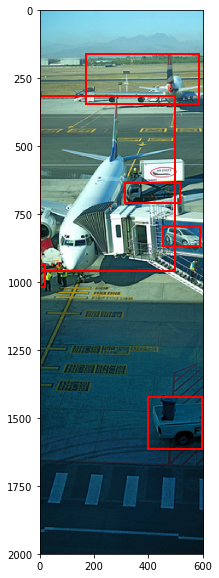

In [6]:
imshow(batch_tensor[0], blobs[0]['boxes'])

Thử hiển thị ảnh cùng các bounding boxes

In [7]:
from faster_rcnn.faster_rcnn_2 import RPN, FastRCNN


### Tính toán feed-forward


Chúng ta sử dụng một ảnh có kích thước đầu vào là  `(width , height) = (600, 800)`

Input:
    - im_data : 
        kích thước : (batch_size, dim, witdh, height)
    - ground_boxes: 
        kích thước (n, 4)
        

In [8]:
categories = ['__background__'] + [x['name'] for x in cap.coco.loadCats(cap.coco.getCatIds())]

In [9]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

/opt/conda/envs/pytorch/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
faster_rcnn/network.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.conv.weight)
faster_rcnn/network.py:54: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.fc.weight)


FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [10]:
features, rois = net.rpn(batch_tensor, im_info, batch_boxes, batch_boxes_index)

In [11]:
param = filter(lambda x: x.requires_grad, net.rpn.parameters())
optimizer = SGD(param, lr=1e-3, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.95)

In [12]:
def train(data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch):

    model.train()
    train_loss = 0
    cross_entropy = 0
    loss_box = 0
    rpn_loss = 0

    for step in range(1, steps_per_epoch +1):
        features, rois = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
        loss = model.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            log_text = 'step %d, loss: %.6f' % (
                step, train_loss /(step))
            print(log_text)



In [13]:
# train(None, optimizer, exp_lr_scheduler, net.rpn, 1, 2000)
# torch.save(net.rpn.state_dict(), 'rpn_2.pkl')

In [14]:
net.rpn.load_state_dict(torch.load('./rpn_2.pkl'))

In [15]:
features, rpn_bbox_pred, rpn_cls_score =  net.rpn._computer_forward(batch_tensor)

In [16]:
feature_height, feature_width = features.shape[2:]
im_height, im_width = batch_tensor.shape[2:]

In [17]:
label, bbox_targets, bbox_inside_weights, bbox_outside_weights = net.rpn.anchor_target_layer(rpn_cls_score, batch_boxes, batch_boxes_index, im_info)

In [18]:
all_anchors = net.rpn.anchor_target_layer._create_anchors(feature_height, feature_width)
# imshow(batch_tensor[0], gt_boxes, all_anchors[])
all_anchors.shape

(55500, 4)

In [19]:
inside_anchors, inside_anchor_indexes = net.rpn.anchor_target_layer._filter_outside_anchors(all_anchors=all_anchors, im_height=im_height, im_width=im_width)

In [20]:
labels, bbox_targets = net.rpn.anchor_target_layer.calculate_target(
    inside_anchors, batch_size, inside_anchor_indexes, batch_boxes, batch_boxes_index)
print labels.shape
labels[0] == 1
print bbox_targets.shape
print bbox_targets[0].shape

(5, 31227)
(5, 31227, 4)
(31227, 4)


In [21]:
print rpn_bbox_pred.shape
print rpn_cls_score.shape

torch.Size([5, 48, 125, 37])
torch.Size([5, 24, 125, 37])


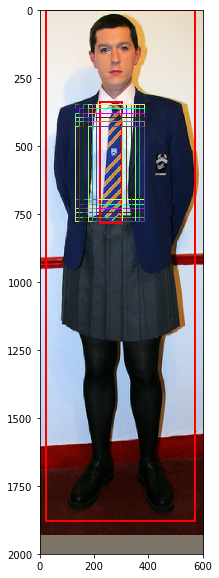

In [22]:
batch_index = 1
imshow(batch_tensor[batch_index],batch_boxes[batch_boxes_index == batch_index], inside_anchors[labels[batch_index] == 1], random=True)

In [23]:
current_targets = bbox_targets[batch_index][labels[batch_index] == 1]
current_anchors = inside_anchors[labels[batch_index] == 1]

In [24]:
source_boxes = bbox_transform_inv(current_anchors[np.newaxis, :] , current_targets[np.newaxis, :])

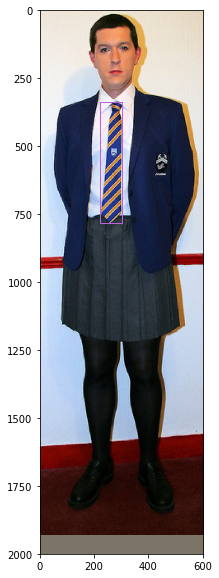

In [25]:
imshow(batch_tensor[batch_index],[], source_boxes[0], random=True)

#### Test RPN 

In [26]:
from torch.nn.functional import smooth_l1_loss, mse_loss, cross_entropy, softmax

features, rpn_bbox_pred, rpn_cls_score = net.rpn._computer_forward(batch_tensor)

rpn_cls_score_reshape = rpn_cls_score.view(
    batch_size, 2, -1, rpn_cls_score.shape[-1])  # batch , 2 , (num_anchors*h) , w
rpn_cls_prob = softmax(rpn_cls_score_reshape, dim=1)
rpn_cls_prob_reshape = rpn_cls_prob.view_as(
    rpn_cls_score)  # batch , h , w , (num_anchors * 2)

print rpn_cls_score.shape
print rpn_cls_prob_reshape.shape

label, bbox_targets, bbox_inside_weights, bbox_outside_weights = net.rpn.anchor_target_layer(rpn_cls_score, batch_boxes, batch_boxes_index, im_info)
print torch.sum(label)

torch.Size([5, 24, 125, 37])
torch.Size([5, 24, 125, 37])
tensor(-2.7585e+05, device='cuda:0')


In [27]:
features, rois = net.rpn(batch_tensor, im_info, batch_boxes, batch_boxes_index)

In [28]:
from torch.nn.functional import smooth_l1_loss, mse_loss, cross_entropy, softmax
smooth_l1_loss(rpn_bbox_pred * bbox_inside_weights, bbox_targets * bbox_inside_weights)

tensor(1.00000e-04 *
       6.6206, device='cuda:0')

In [29]:
from faster_rcnn.network import smooth_l1_loss as smooth_l1_loss_2 
print smooth_l1_loss_2(rpn_bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=3.0, dim=[1, 2, 3])
# print bbox_inside_weights

tensor(0.7246, device='cuda:0')


In [30]:
mse_loss(rpn_bbox_pred * bbox_inside_weights, bbox_targets * bbox_inside_weights)

tensor(1.00000e-03 *
       1.5026, device='cuda:0')

In [31]:
label_numpy = label.cpu().detach().numpy().reshape(5, -1, feature_height,feature_width).transpose((0, 2, 3, 1)).reshape(batch_size, -1, 1)
rpn_cls_prob_numpy = rpn_cls_prob_reshape.cpu().detach().numpy().reshape(5, -1, feature_height,feature_width)[:, 12:, :,:].transpose((0, 2, 3, 1)).reshape(batch_size, -1, 1)

In [32]:
from sklearn.metrics import roc_curve, auc
tmp_label = label_numpy.reshape(-1)
tmp_result = rpn_cls_prob_numpy.reshape(-1)
print label_numpy.shape
print label_numpy[np.where(label_numpy == 0)]
print rpn_cls_prob_numpy[np.where(label_numpy == 0)]




fpr, tpr , _ = roc_curve(tmp_label[np.argwhere(tmp_label != -1)], tmp_result[np.argwhere(tmp_label != -1)])
roc_auc = auc(fpr, tpr)

(5, 55500, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

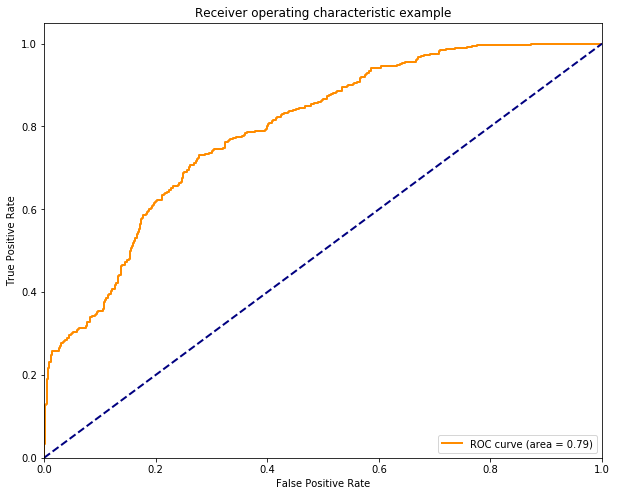

In [33]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [34]:
features, rois = net.rpn(batch_tensor, im_info, batch_boxes, batch_boxes_index)

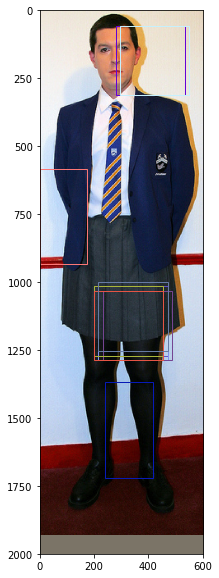

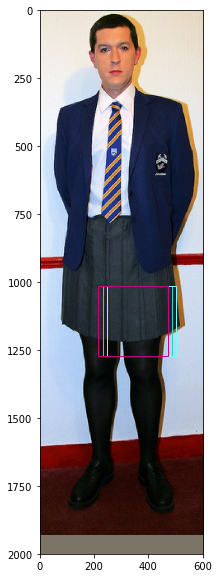

In [35]:
imshow(batch_tensor[1],[], all_anchors[[31782, 32226, 32238, 31770,  5190, 32214,  5202, 20938, 42874, 31338], :], random=True)
imshow(batch_tensor[1],[], all_anchors[[31794 , 31806 ,31782], :], random=True)

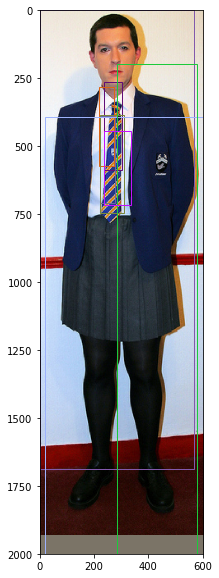

In [36]:
roi_numpy = rois[batch_index, :, 1:].cpu().detach().numpy()
imshow(batch_tensor[batch_index],[], roi_numpy[:30:4], random=True)

In [37]:
proposal_target_layer = ProposalTargetLayer(len(categories))

In [38]:
roi_data = proposal_target_layer(rois, batch_boxes, batch_boxes_index)
print roi_data[0].shape
print roi_data[1].shape
print roi_data[2].shape
print roi_data[3].shape

torch.Size([1500, 5])
torch.Size([1500, 1])
torch.Size([1500, 324])
torch.Size([1500, 324])


In [39]:
from faster_rcnn.roi_pooling.modules.roi_pool import RoIPool

In [40]:
roi_pooling = RoIPool(7, 7, 1.0 / 16)

In [41]:
result = roi_pooling(features, roi_data[0])

In [42]:
result.shape

torch.Size([1500, 512, 7, 7])